In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
import warnings

from src import data, paths, centroids, matrix_filtering, communicatin_metrics, plotting, labels

%matplotlib inline

!date -I

2024-05-12


## Settings

In [2]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION = "MNI-HCP-MMP1"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False

# True for 50 ms version, 200 ms version otherwise
FTRACT_SHORT = False

ED_THRESHOLD = 0
MIN_STREAMLINES = 5
GRAPH_DENSITY = 0.25

selected_SC_matrices = ["Mica-Mics_rh"] # "Rosen-Halgren_rh"

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

In [3]:
fig_dir = f"ftract_results_per_roi/{'short' if FTRACT_SHORT else 'long'}/{PARCELLATION}/ED{ED_THRESHOLD}/{GRAPH_DENSITY}/"
%mkdir -p  {paths.path_figures(fig_dir)}

## Load data

### Load F-TRACT data

In [4]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
response_probability, response_amplitude, response_onset_delay, response_peak_delay, n_stim, n_impl, ftract_labels = data.load_ftract(PARCELLATION,short=FTRACT_SHORT)

if PARCELLATION == "DKT":
    for a in [0,1]:
        response_probability = np.delete(response_probability,ids_to_delete_in_dkt,axis=a)
        response_amplitude = np.delete(response_amplitude,ids_to_delete_in_dkt,axis=a)
        response_onset_delay = np.delete(response_onset_delay,ids_to_delete_in_dkt,axis=a)
        response_peak_delay = np.delete(response_peak_delay,ids_to_delete_in_dkt,axis=a)
        n_stim = np.delete(n_stim,ids_to_delete_in_dkt,axis=a)
        n_impl = np.delete(n_impl,ids_to_delete_in_dkt,axis=a)

In [5]:
idx_m1_l, idx_m1_r = list(ftract_labels).index("L_4"), list(ftract_labels).index("R_4") # location of primary motor cortex
idx_m1_l, idx_m1_r

(111, 291)

In [6]:
np.sum(n_stim[idx_m1_l]), np.sum(n_stim[idx_m1_r])

(60283.0, 46043.0)

In [7]:
np.count_nonzero(n_stim[idx_m1_l]), np.count_nonzero(n_stim[idx_m1_r])

(285, 285)

In [8]:
np.sum(n_impl[idx_m1_l]), np.sum(n_impl[idx_m1_r])

(3347.0, 3457.0)

In [9]:
np.count_nonzero(n_impl[idx_m1_l]), np.count_nonzero(n_impl[idx_m1_r])

(285, 285)

### Load Euclidean distances

In [10]:
if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    
elif PARCELLATION == "MNI-HCP-MMP1":
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)

### Define mask

In [11]:
mask = np.logical_and(np.logical_and(n_stim > 100, n_impl > 5),ED>ED_THRESHOLD)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    mask_amp = mask
else:
    mask_amp = (n_stim*response_probability)>=100

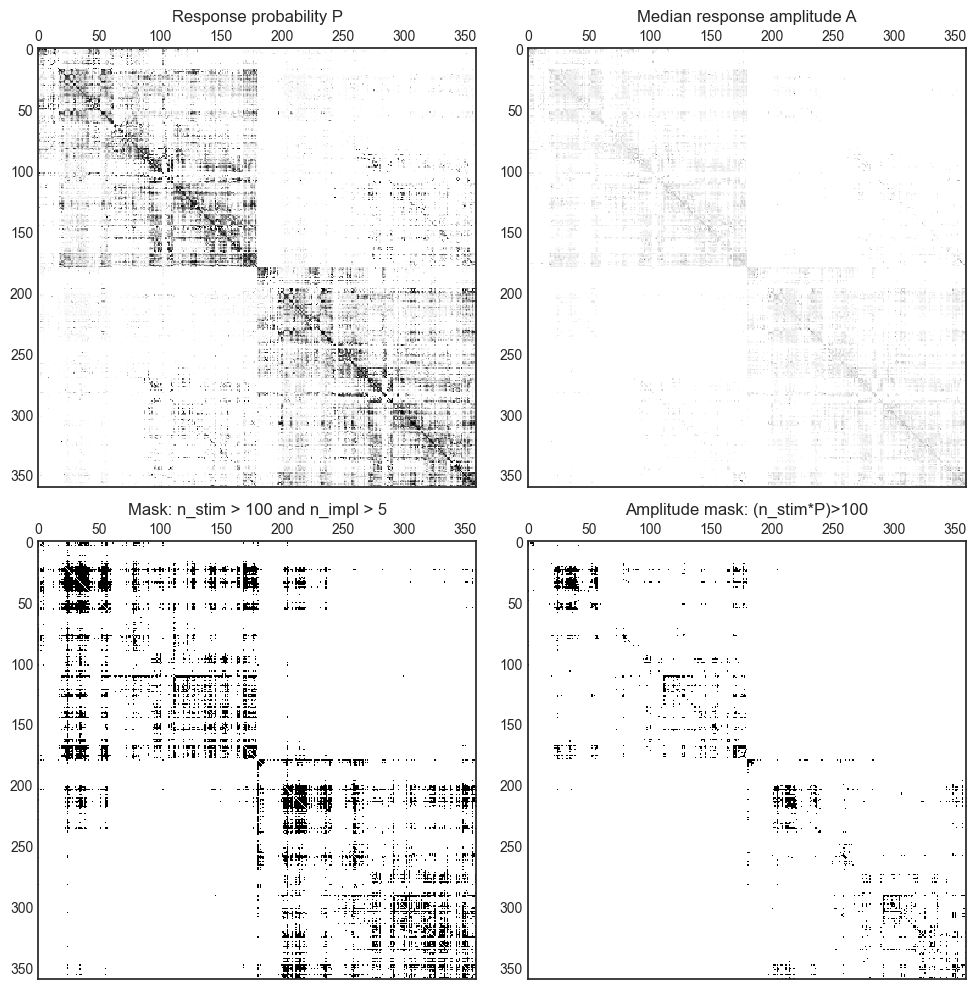

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].matshow(response_probability)
axs[0,0].set_title("Response probability P")
axs[0,1].matshow(np.log(response_amplitude))
axs[0,1].set_title("Median response amplitude A")
axs[1,0].matshow(mask)
axs[1,0].set_title("Mask: n_stim > 100 and n_impl > 5")
axs[1,1].matshow(mask_amp)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    axs[1,1].set_title("Amplitude mask same as mask")
else:
    axs[1,1].set_title("Amplitude mask: (n_stim*P)>100")

### Load structural connectivity data

In [13]:
SC_matrices = []

if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ids_to_delete_in_dkt,ED,min_streamlines_count=MIN_STREAMLINES)
    

elif PARCELLATION == "MNI-HCP-MMP1":
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ED,min_streamlines_count=MIN_STREAMLINES)

number_of_SC = len(SC_matrices)

/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


In [14]:
SC_matrices_filtered = []

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data
    pivot = matrix_filtering.find_pivot_to_keep_xpercent_edges(SC_W,GRAPH_DENSITY)
    SC_W = np.where(SC_W>=pivot,SC_W,0)
    if SC_L is not None:
        SC_L = np.where(SC_W>=pivot,SC_L,np.nan)
    SC_W_log = np.where(SC_W>=pivot,SC_W_log,np.nan)
    SC_matrices_filtered.append((name, SC_W, SC_L, SC_W_log))

SC_matrices = SC_matrices_filtered

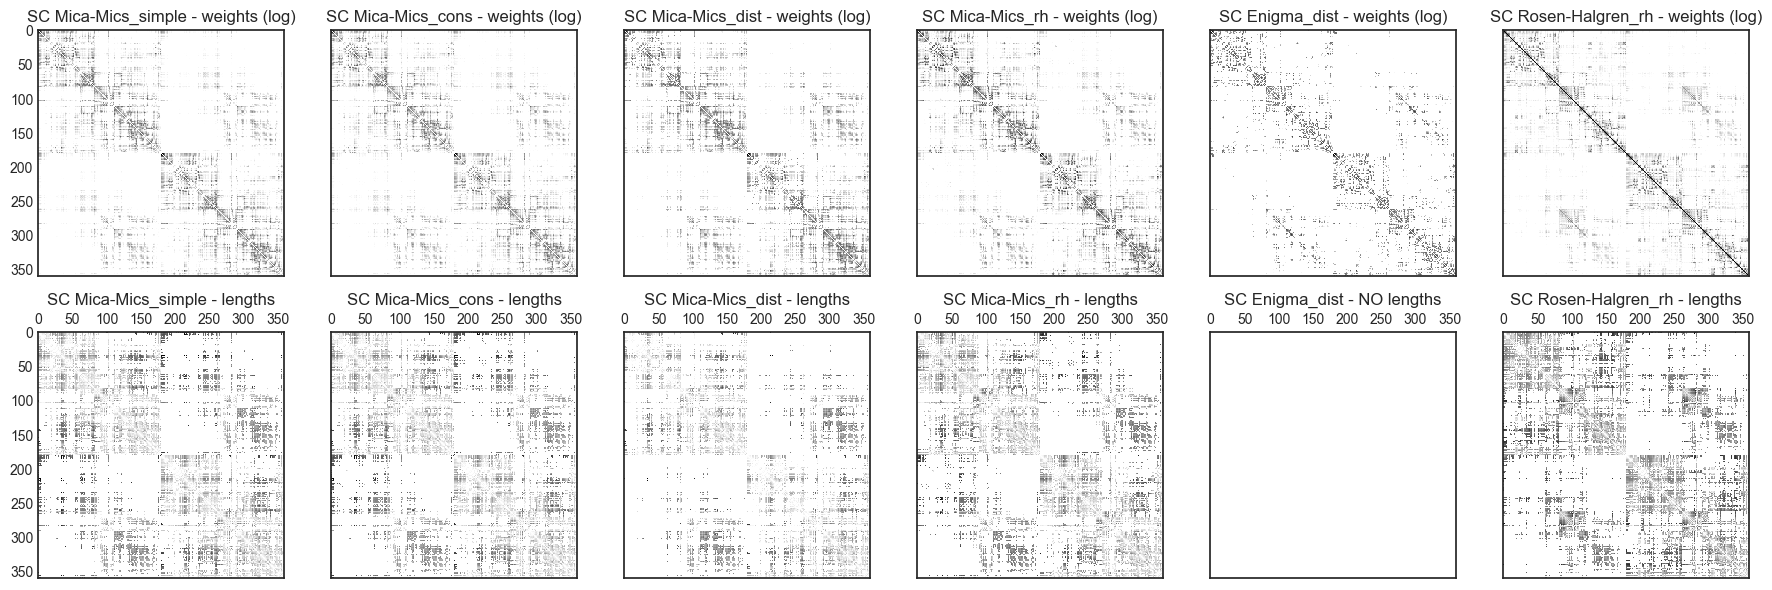

In [15]:
plt.rcParams['figure.figsize'] = [3*number_of_SC,6]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")

    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

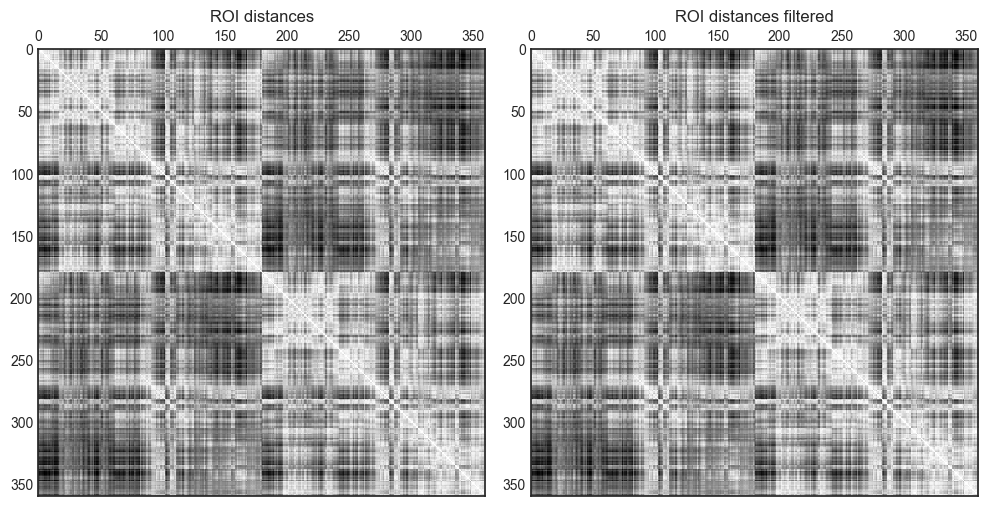

In [16]:
if ED is not None:
    fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(10,5))

    axs[0].matshow(ED)
    axs[0].set_title("ROI distances")
    ED_filtered = np.where(ED>ED_THRESHOLD,ED,np.nan)
    axs[1].matshow(ED_filtered)
    axs[1].set_title("ROI distances filtered")
    plt.show()

## Correlations

In [17]:
def df_per_roi(response,mask,metrics_dict,ftract_labels):

    masked_response = np.where(mask,response,np.nan)

    temp = dict()
    for roi,label in enumerate(ftract_labels):
        df_per_roi = pd.DataFrame()
        response_per_roi = masked_response[roi,:]
        if np.isnan(response_per_roi).all():
            continue
        df_per_roi["response"] = pd.Series(response_per_roi)
        for m in metrics_dict:
            m_masked = metrics_dict[m]
            df_per_roi[m] = pd.Series(m_masked[roi,:])

        temp[label] = df_per_roi
    
    df = pd.concat(temp)
        
    return df

In [18]:
stat_data_per_roi = {}

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    if name not in selected_SC_matrices:
        continue

    # this is necessary to supress warnings for some types of matrices
    if SC_L is not None:
        SC_L = np.ascontiguousarray(SC_L)
    SC_W = np.ascontiguousarray(SC_W)

    # supress warnings - all the warnings we saw were about zero division,
    # they result into nans in matrices, but they can not cause any issues
    # (we checked the code where the warnings occured)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        metrics_dict = communicatin_metrics.calculate_communicatin_metrics(ED,SC_L,SC_W)

    df_probability = df_per_roi(response_probability,mask,metrics_dict,ftract_labels)
    df_amplitude = df_per_roi(response_amplitude,mask_amp,metrics_dict,ftract_labels)

    stat_data_per_roi[name] = {"probability":df_probability,"amplitude":df_amplitude}

In [19]:
def partial_corr_ED(d,x,method):
    result = []
    result.append(pd.DataFrame({"n":[0],"r":[0],"CI95%":[None],"p-val":[1],"Y":["ED"]})) # just to have fitting images

    for k in d.keys():
        if k == "ED" or k == x or np.count_nonzero(d[x])<3 or np.count_nonzero(d[k])<3:
            continue
        df_one_result = pg.partial_corr(data=d,x=x,y=k,covar="ED", method=method)
        df_one_result['Y'] = k
        result.append(df_one_result)
    
    return pd.concat(result)

def corr_per_roi(df):
    r_per_roi = dict()
    for label in list(set(df.index.get_level_values(0))):
        relevant_df = df.xs(label, drop_level=False)

        try:
            r_per_roi[label] = pg.pairwise_corr(relevant_df,'response', method='spearman').round(3)
        except:
            pass # we need enoug non-zero values, otherwise the correlation does not make sense
        
    return pd.concat(r_per_roi)

def partial_corr_per_roi(df):
    r_per_roi = dict()
    for label in list(set(df.index.get_level_values(0))):
        relevant_df = df.xs(label, drop_level=False)
        try:
            r_per_roi[label] = partial_corr_ED(relevant_df,'response', method='spearman').round(3)
        except:
            pass # we need enoug non-zero values, otherwise the correlation does not make sense
    return pd.concat(r_per_roi)

In [20]:
keys = []

result_p_per_roi = []
result_p_partial_per_roi = []


for name in selected_SC_matrices:
    print(name)
    keys.append(name)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        # supress warnings about small number of examples (it returns nans if sample size is too small, which is ok in this case)
        result_p_per_roi.append(corr_per_roi(stat_data_per_roi[name]["probability"]).round(3))
        result_p_partial_per_roi.append(partial_corr_per_roi(stat_data_per_roi[name]["probability"]))

Mica-Mics_rh


In [21]:
for r in result_p_per_roi+result_p_partial_per_roi:
    r['r_abs'] = r['r'].apply(abs)
for r in result_p_per_roi:
    r['p_sigf'] = r['p-unc'].apply(lambda x: "*" if x< 0.05 else "")
    r['p_sigf_num'] = r['p_sigf'].apply(lambda x: 1 if x=="*" else 0)
    r['r_abs_sigf'] = r.apply(lambda x: x['r_abs'] if (x['p-unc'] < 0.05 and x['n']>=30) else np.nan,axis=1)
for r in result_p_partial_per_roi:
    r['p_sigf'] = r['p-val'].apply(lambda x: "*" if x< 0.05 else "")
    r['p_sigf_num'] = r['p_sigf'].apply(lambda x: 1 if x=="*" else 0)
    r['r_abs_sigf'] = r.apply(lambda x: x['r_abs'] if (x['p-val'] < 0.05 and x['n']>=30) else np.nan,axis=1)

result_p_per_roi = pd.concat(result_p_per_roi, keys=keys).reset_index(names=["dataset","roi",'-'])
result_p_partial_per_roi = pd.concat(result_p_partial_per_roi, keys=keys).reset_index(names=["dataset","roi",'-'])

In [22]:
plt.style.use('ggplot')
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#E24A33', '#348ABD', '#8EBA42','#FBC15E', '#777777', '#988ED5', '#FFB5B8']) 

In [23]:
def plot_results(d,title):
    plt.figure(figsize=(7,10))
    
    ax = sns.barplot(data=d, x='Y', y='r_abs',hue="dataset")
    ax.set_title(title)  
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)

    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')

    plt.show()

In [24]:
def plot_results_per_roi(rpr,title=None):
    plt.figure(figsize=(7,7))
    
    ax = sns.boxplot(data=rpr, x="Y", y="r_abs_sigf", hue="dataset",palette=['#E24A33','#777777'])
    ax.set_title(title) 
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)
    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')
    title_save = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(f'{paths.path_figures(fig_dir+title_save)}.pdf')
    plt.show()

In [25]:
for rpr in [result_p_per_roi,result_p_partial_per_roi]:#,result_a_per_roi,result_a_partial_per_roi]:
    display(rpr.groupby(by=["dataset","Y"])[['r','p_sigf_num','n']].agg({'r':'mean','p_sigf_num':'sum','n':'mean'}))

r  p_sigf_num          n
dataset      Y                                     
Mica-Mics_rh COM    0.651761         224  33.790698
             DIF    0.160561          18  33.790698
             ED    -0.689070         237  33.790698
             NAV    0.690894         240  33.790698
             SC_L  -0.645098         233  33.790698
             SC_W   0.602515         221  33.790698
             SI    -0.602515         221  33.790698
             SI_L  -0.626153         224  33.790698
             SPE    0.708086         241  33.790698
             SPE_W  0.637193         219  33.790698

r  p_sigf_num          n
dataset      Y                                     
Mica-Mics_rh COM    0.332913         144  36.545126
             DIF    0.094823          34  36.545126
             ED     0.000000           0   0.000000
             NAV    0.345343         157  36.545126
             SC_L  -0.318744         141  36.545126
             SC_W   0.297404         135  36.545126
             SI    -0.297404         135  36.545126
             SI_L  -0.315668         128  36.545126
             SPE    0.342051         152  36.545126
             SPE_W  0.337235         141  36.545126

/tmp/ipykernel_4115/4108073624.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.boxplot(data=rpr, x="Y", y="r_abs_sigf", hue="dataset",palette=['#E24A33','#777777'])


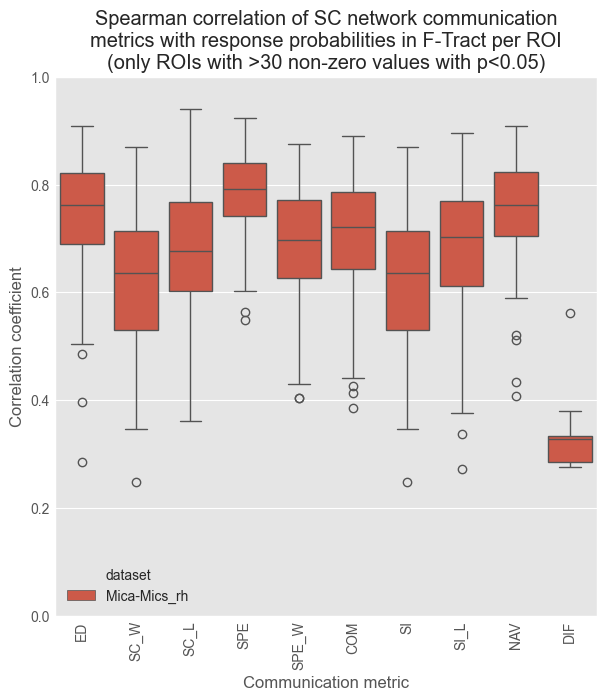

/tmp/ipykernel_4115/4108073624.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.boxplot(data=rpr, x="Y", y="r_abs_sigf", hue="dataset",palette=['#E24A33','#777777'])


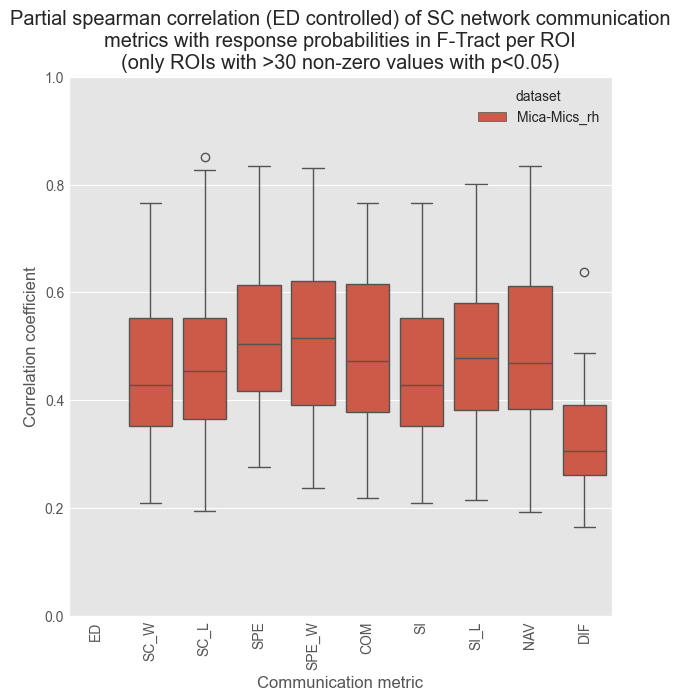

In [26]:
plot_results_per_roi(result_p_per_roi,title="Spearman correlation of SC network communication\nmetrics with response probabilities in F-Tract per ROI\n(only ROIs with >30 non-zero values with p<0.05)")
plot_results_per_roi(result_p_partial_per_roi,title="Partial spearman correlation (ED controlled) of SC network communication\nmetrics with response probabilities in F-Tract per ROI\n(only ROIs with >30 non-zero values with p<0.05)")

In [27]:
stat_m = {}
stat_m_partial = {}

for name in selected_SC_matrices:
    primary_motor_cortex_l = stat_data_per_roi[name]["probability"].loc["L_4"]
    print("L",np.count_nonzero(primary_motor_cortex_l))
    stat_l = pg.pairwise_corr(primary_motor_cortex_l,'response', method='spearman').round(3)
    stat_l_partial = partial_corr_ED(primary_motor_cortex_l,'response', method='spearman').round(3)

    primary_motor_cortex_r = stat_data_per_roi[name]["probability"].loc["R_4"]
    print("R",np.count_nonzero(primary_motor_cortex_r))
    stat_r = pg.pairwise_corr(primary_motor_cortex_r,'response', method='spearman').round(3)
    stat_r_partial = partial_corr_ED(primary_motor_cortex_r,'response', method='spearman').round(3)

    stat = pd.concat({"L_hemi":stat_l,"R_hemi":stat_r})
    stat = stat.reset_index(names=["hemi",'-'])
    stat["r_abs"] = abs(stat["r"])
    stat_m[name] = stat

    stat_partial = pd.concat({"L_hemi":stat_l_partial,"R_hemi":stat_r_partial})
    stat_partial = stat_partial.reset_index(names=["hemi",'-'])
    stat_partial["r_abs"] = abs(stat_partial["r"])
    stat_m_partial[name] = stat_partial

stat_m_df = pd.concat(stat_m).reset_index(names=["dataset",'--'])
stat_m_df_partial = pd.concat(stat_m_partial).reset_index(names=["dataset",'--'])

L 3723
R 3709


In [28]:
stat_m_df_partial

,dataset,--,hemi,-,n,r,CI95%,p-val,Y,r_abs
0,Mica-Mics_rh,0,L_hemi,0,0,0.000,None,1.000,ED,0.000
1,Mica-Mics_rh,1,L_hemi,spearman,125,0.275,"[0.1, 0.43]",0.002,SC_W,0.275
2,Mica-Mics_rh,2,L_hemi,spearman,125,-0.358,"[-0.5, -0.19]",0.000,SC_L,0.358
3,Mica-Mics_rh,3,L_hemi,spearman,125,0.309,"[0.14, 0.46]",0.000,SPE,0.309
4,Mica-Mics_rh,4,L_hemi,spearman,125,0.237,"[0.06, 0.4]",0.008,SPE_W,0.237
5,Mica-Mics_rh,5,L_hemi,spearman,125,0.326,"[0.16, 0.47]",0.000,COM,0.326
6,Mica-Mics_rh,6,L_hemi,spearman,125,-0.275,"[-0.43, -0.1]",0.002,SI,0.275
7,Mica-Mics_rh,7,L_hemi,spearman,125,-0.080,"[-0.25, 0.1]",0.375,SI_L,0.080
8,Mica-Mics_rh,8,L_hemi,spearman,125,0.284,"[0.11, 0.44]",0.001,NAV,0.284
9,Mica-Mics_rh,9,L_hemi,spearman,125,0.034,"[-0.14, 0.21]",0.707,DIF,0.034


In [29]:
stat_m_df['r_abs'] = stat_m_df['r'].apply(abs)
stat_m_df['p_sigf'] = stat_m_df['p-unc'].apply(lambda x: "*" if x< 0.05 else "")

stat_m_df_partial['r_abs'] = stat_m_df_partial['r'].apply(abs)
stat_m_df_partial['p_sigf'] = stat_m_df_partial['p-val'].apply(lambda x: "*" if x< 0.05 else "")

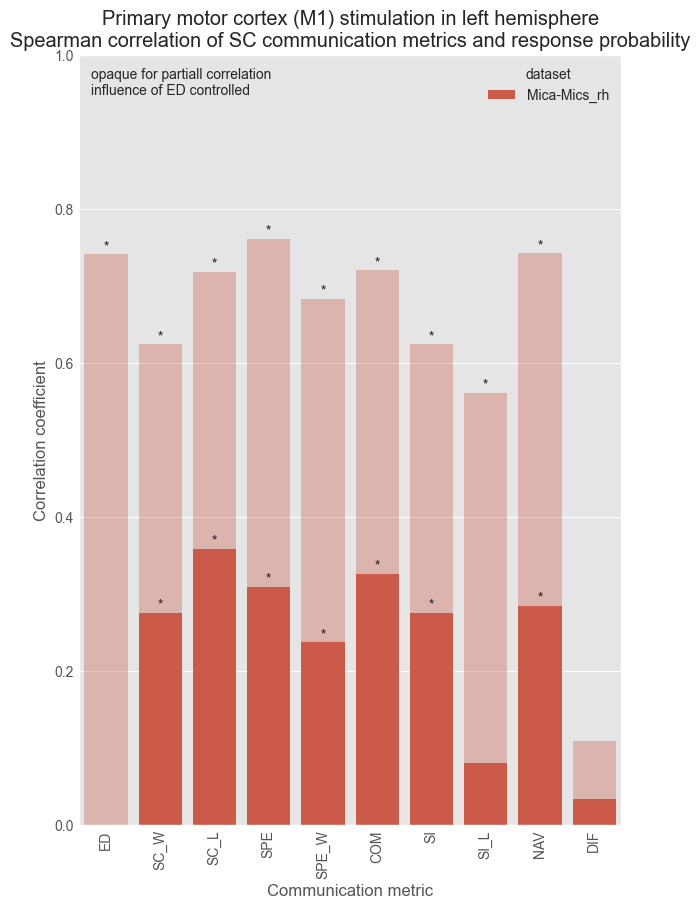

In [30]:
df_lhemim1 = stat_m_df[stat_m_df.hemi=="L_hemi"].copy()
df_lhemim1_partial = stat_m_df_partial[stat_m_df_partial.hemi=="L_hemi"].copy()

title="Primary motor cortex (M1) stimulation in left hemisphere\nSpearman correlation of SC communication metrics and response probability"
plotting.plot_results_overlay(df_lhemim1,df_lhemim1_partial,title=title,fig_dir=fig_dir)

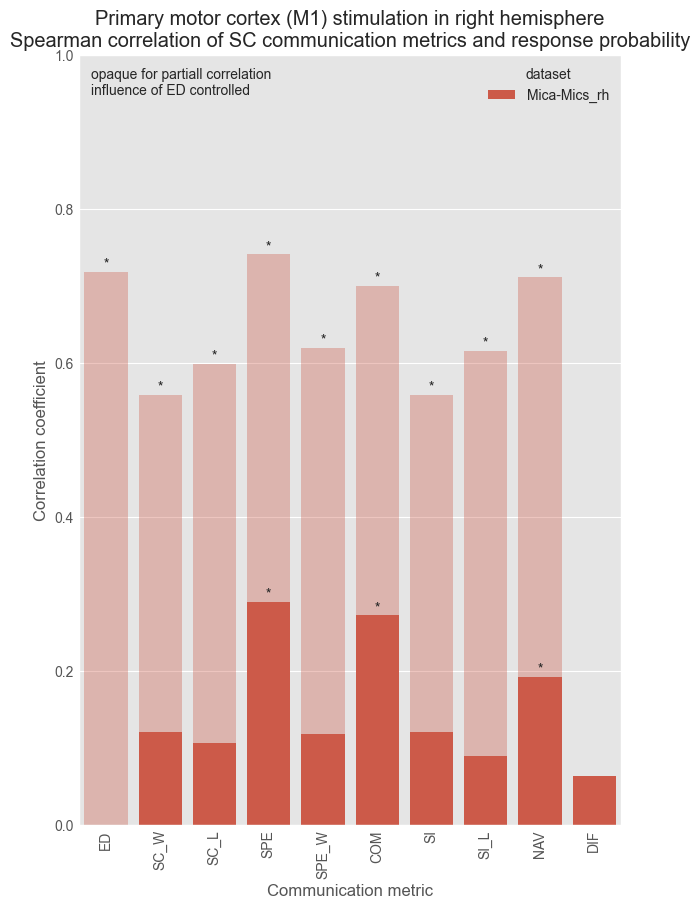

In [31]:
df_rhemim1 = stat_m_df[stat_m_df.hemi=="R_hemi"].copy()
df_rhemim1_partial = stat_m_df_partial[stat_m_df_partial.hemi=="R_hemi"].copy()

title="Primary motor cortex (M1) stimulation in right hemisphere\nSpearman correlation of SC communication metrics and response probability"
plotting.plot_results_overlay(df_rhemim1,df_rhemim1_partial,title=title,fig_dir=fig_dir)

In [32]:
ftract_labels = data.ftract_compatible_glasser_labels()

In [33]:
primary_motor_cortex_l = primary_motor_cortex_l.copy()
primary_motor_cortex_l["label"] = ftract_labels
primary_motor_cortex_l = primary_motor_cortex_l.set_index("label")
primary_motor_cortex_l

,response,ED,SC_W,SC_L,SPE,SPE_W,COM,SI,SI_L,NAV,DIF
label,,,,,,,,,,,
L_V1,NaN,86.733295,0.0,inf,0.010308,0.004043,0.000262,inf,17.289716,0.005749,0.002776
L_MST,NaN,66.763480,0.0,inf,0.010650,0.005580,0.000383,inf,12.452376,0.008141,0.001962
L_V6,NaN,82.434470,0.0,inf,0.010378,0.003974,0.000197,inf,17.181117,0.005880,0.002461
L_V2,NaN,82.496483,0.0,inf,0.009055,0.004073,0.000247,inf,12.868701,0.006706,0.002764
L_V3,NaN,85.616660,0.0,inf,0.009372,0.004269,0.000183,inf,19.851451,0.007832,0.002849
...,...,...,...,...,...,...,...,...,...,...,...
R_STSva,NaN,82.234737,0.0,inf,0.008525,0.006676,0.000528,inf,21.029001,0.007312,0.001664
R_TE1m,NaN,89.386577,0.0,inf,0.008245,0.005509,0.001009,inf,13.976153,0.007279,0.002676
R_PI,NaN,76.150192,0.0,inf,0.008098,0.005653,0.000498,inf,20.653869,0.007442,0.001153


In [34]:
primary_motor_cortex_l.to_csv(paths.path(f"interim/response_probability_and_communication_metrics_M1_FTRACT_ED{ED_THRESHOLD}_{'short' if FTRACT_SHORT else 'long'}.csv"))